# **Description**

1st stage training is implementated with 17 class data.
2nd stage training is implemented with 9 class data without freezing the pretrained layers. Data is normalised, augmented. Accuracy is achieved 76% and 92% for 1st stage and 2nd stage training accordingly. But cannot identify diseases in testing section.

# **Stage one training**

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/My Drive/Research/Rice disease"
#!ls "/content/drive/My Drive/Research/Rice disease"
!ls

Mounted at /content/drive/
/content/drive/My Drive/Research/Rice disease
'2step cnn.ipynb'   model1_weights.h5		  vgg16_2.ipynb
 blast.jpg	    model_weights.h5		  VGG16.ipynb
 data		    Pretrained_model_weights.h5
 hispa.jpg	    Resized_Original_Data


In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/Research/Rice disease/data/SYMPTOM_Resized')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

1426


In [ ]:
batch_size = 64
img_height = 224
img_width = 224

In [ ]:
train_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1426 files belonging to 17 classes.
Using 1141 files for training.


In [ ]:
val_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1426 files belonging to 17 classes.
Using 285 files for validation.


In [ ]:
class_names = train_ds1.class_names
print(class_names)

['BLB1', 'BPH1', 'BPH2', 'Brown_Spot1', 'False_Smut1', 'False_Smut2', 'Healthy1', 'Healthy2', 'Healthy3', 'Hispa1', 'Hispa2', 'Neck_Blast1', 'Sheath_Blight_Rot1', 'Sheath_Blight_Rot2', 'Sheath_Blight_Rot3', 'Stemborer1', 'Stemborer2']


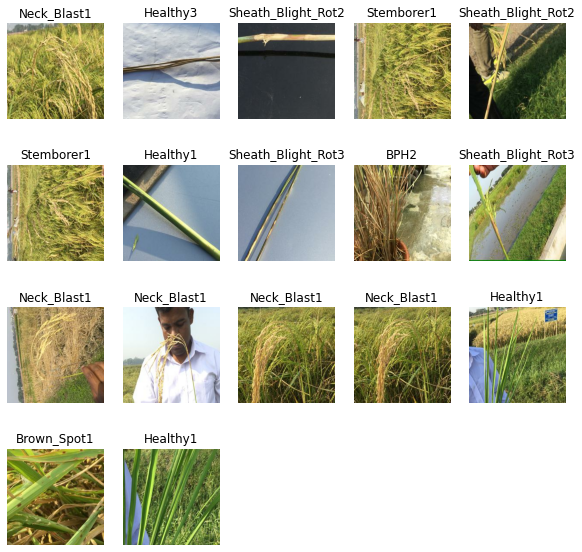

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(17):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds1:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds1 = train_ds1.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds1 = val_ds1.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
   layers.RandomFlip("vertical"),
   layers.RandomRotation(factor=(-0.15, 0.15)),
   layers.RandomRotation([0, 90, 180, 270]),
   #layers.RandomDistortion(0.2),
   layers.RandomContrast(0.1),
   layers.RandomZoom(0.1),
   layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
   #layers.RandomTranslation(0.1, 0.1)
   #layers.RandomRotation(0.1),
   #layers.RandomZoom(0.1),
  ]
)

train_ds1 = train_ds1.map(lambda x, y: (data_augmentation(x), y))
val_ds1 = val_ds1.map(lambda x, y: (data_augmentation(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
#normalization_layer = layers.Rescaling(1./255)

In [ ]:
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [ ]:
#kfold = StratifiedKFold(n_splits=1, shuffle=True, random_state=None)
#cvscores = []
#for train, test in kfold.split(images, labels):
premodel = Sequential()
#model.add(Rescaling(1./255, input_shape=(224, 224, 3))),
premodel.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)))
premodel.add(BatchNormalization())
premodel.add(Activation('relu'))
#premodel.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
premodel.add(MaxPooling2D(pool_size=(2, 2)))

premodel.add(Conv2D(24, (3, 3), padding='same'))
#premodel.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
premodel.add(BatchNormalization())
premodel.add(Activation('relu'))
premodel.add(MaxPooling2D(pool_size=(2, 2)))

premodel.add(Conv2D(32, (3, 3), padding='same'))
#premodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#premodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
premodel.add(BatchNormalization())
premodel.add(Activation('relu'))
premodel.add(MaxPooling2D(pool_size=(2, 2)))

premodel.add(Conv2D(48, (3, 3),  padding='same'))
#premodel.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
#premodel.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
premodel.add(BatchNormalization())
premodel.add(Activation('relu'))
premodel.add(MaxPooling2D(pool_size=(2, 2)))

premodel.add(Conv2D(64, (3, 3),  padding='same'))
#premodel.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#premodel.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
premodel.add(BatchNormalization())
premodel.add(Activation('relu'))
premodel.add(MaxPooling2D(pool_size=(2, 2)))

premodel.add(Flatten())

#premodel.add(Dense(128, activation='relu'))
#premodel.add(Dropout(0.5))
premodel.add(Dense(256, activation='relu'))
premodel.add(Dropout(0.3))
premodel.add(Dense(128, activation='relu'))
premodel.add(Dense(17, activation='softmax'))


opt = Adam(lr=0.0001)
premodel.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
epochs=100
history1 = premodel.fit(
train_ds1,
validation_data=val_ds1,
epochs=epochs)

  #cvscores.append(val_accuracy)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 [==============================] - 119s 3s/step - loss: 2.8008 - accuracy: 0.1613 - val_loss: 2.7984 - val_accuracy: 0.1158
Epoch 2/100
18/18 [==============================] - 30s 2s/step - loss: 2.5166 - accuracy: 0.1849 - val_loss: 2.8033 - val_accuracy: 0.1263
Epoch 3/100
18/18 [==============================] - 32s 2s/step - loss: 2.3628 - accuracy: 0.2401 - val_loss: 2.7574 - val_accuracy: 0.1719
Epoch 4/100
18/18 [==============================] - 30s 2s/step - loss: 2.2871 - accuracy: 0.2954 - val_loss: 2.7160 - val_accuracy: 0.1123
Epoch 5/100
18/18 [==============================] - 30s 2s/step - loss: 2.2281 - accuracy: 0.2989 - val_loss: 2.6663 - val_accuracy: 0.1579
Epoch 6/100
18/18 [==============================] - 29s 2s/step - loss: 2.1456 - accuracy: 0.3252 - val_loss: 2.5727 - val_accuracy: 0.2035
Epoch 7/100
18/18 [==============================] - 32s 2s/step - loss: 2.0746 - accuracy: 0.3628 - val_loss: 2.4196 - val_accuracy: 0.2667
Epoch 8/100
18/18 [=====

In [ ]:
premodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 24)      3480      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 24)    

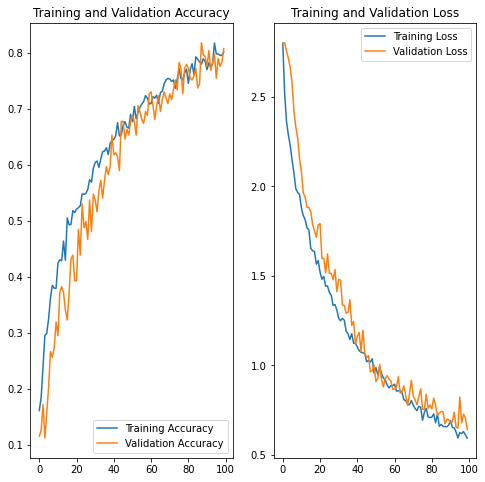

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the premodel weights to a file

weights_dir = '/content/drive/My Drive/Research/Rice disease'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

weights_filename = os.path.join(weights_dir, 'Pretrained_model_weights.h5')
premodel.save_weights(weights_filename)

print('Model weights saved to:', weights_filename)

Model weights saved to: /content/drive/My Drive/Research/Rice disease/Pretrained_model_weights.h5


In [ ]:

#from keras.optimizers import Adam
#opt = Adam(lr=0.0001)
#premodel.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


# **2nd model**

In [ ]:
import pathlib
data_dir2 = pathlib.Path('/content/drive/My Drive/Research/Rice disease/data/Resized_Original_Data')

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1426 files belonging to 9 classes.
Using 1141 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1426 files belonging to 9 classes.
Using 285 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
   layers.RandomFlip("vertical"),
   layers.RandomRotation(factor=(-0.15, 0.15)),
   layers.RandomRotation([0, 90, 180, 270]),
   #layers.RandomDistortion(0.2),
   layers.RandomContrast(0.1),
   layers.RandomZoom(0.1),
   layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
   #layers.RandomTranslation(0.1, 0.1)
   #layers.RandomRotation(0.1),
   #layers.RandomZoom(0.1),
  ]
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# Add new layers for fine-tuning
model = Sequential()
#model.add(premodel)


# Add the layers except last layer from premodel to the new model
#model.add(premodel.layers[:-1])
for layer in premodel.layers[:-1]:
    model.add(layer)

model.add(Dense(9, activation='softmax', name='new_dense2'))

# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#premodel = Sequential()
weights_dir = '/content/drive/My Drive/Research/Rice disease'
weights_filename = os.path.join(weights_dir, 'Pretrained_model_weights.h5')
model.load_weights(weights_filename)
#num_layers = len(premodel.layers)
#print(num_layers)

# Freeze the weights of the first few layers
#for layer in premodel.layers[:24]:
 # layers.trainable = False
#layers.trainable = False

ValueError: ignored

In [ ]:
model.summary()

In [ ]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
epochs=100
history2 = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs)

In [ ]:
#epochs=10
#history = premodel.fit(
 # train_ds,
 # validation_data=val_ds,
 # epochs=epochs)

#history = premodel.fit(steps_per_epoch=len(train_ds)//batch_size,train_data=train_ds, validation_data= val_ds,validation_steps=len(val_ds)//batch_size,epochs=epochs)

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
#test_dir3 = pathlib.Path('/content/drive/My Drive/Research/Rice disease/data/SYMPTOM_Resized/Healthy1/h2.jpeg')
#test_dir1 = pathlib.Path('/content/drive/My Drive/Research/Rice disease/data/SYMPTOM_Resized/Hispa1/Hispa1.jpeg')
test_dir2 = pathlib.Path('/content/drive/My Drive/Research/Rice disease/data/SYMPTOM_Resized/BPH2/BPH2.jpeg')
#test_dir = pathlib.Path('/content/drive/My Drive/Research/Rice disease/hispa.jpg')
#test_dir = pathlib.Path('/content/drive/My Drive/Research/Rice disease/blast.jpg')



img = tf.keras.utils.load_img(
    test_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)